# Extracting condition-specific trials

The aim of this section is to extract the trials according to the trigger channel. We will explain how the events can be generated from the stimulus channels and how to extract condition specific trials (epochs). Once the trials are extracted, bad epochs will be identified and excluded on based on their peak-to-peak signal amplitude.

## Preparation

Import the relevant Python modules:

In [1]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids


Set the paths for the data and results. Note that these will depend on your local setup.

In [16]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '01'  # we have two runs for this subject, let's look at run = 1
meg_suffix = 'meg'
ica_suffix = 'ica'
epo_suffix = 'epo'

deriv_root = r'Z:\Projects\FLUX\MEG_data\Course\derivatives'  # path of the derivatives, similar structure to bids raw data 
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=ica_suffix, datatype='meg',
            root=deriv_root, extension='fif', check=False)
print(bids_path.basename,bids_path.fpath)
                      
deriv_fname = bids_path.basename.replace(ica_suffix, epo_suffix)
deriv_file_1 = op.join(bids_path.directory, deriv_fname)
deriv_file = deriv_file_1.replace('run-01', 'run-12')  # we can't use the update function because the deriv files have not yet been created
print(deriv_file)

# define the bids path to raw data and events file
raw_path = bids_path.copy().update(root=r'Z:\Projects\FLUX\MEG_data\Course\openneuro', 
                                suffix='events', extension='tsv', check=False)
print(raw_path.fpath)

sub-01_ses-01_task-SpAtt_run-01_ica.fif Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif
Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-12_epo.fif
Z:\Projects\FLUX\MEG_data\Course\openneuro\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_events.tsv


C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\1159313676.py:10: FutureWarning: extension should start with a period ".", but got: "fif". Prepending "." to form: ".fif". This will raise an exception starting with MNE-BIDS 0.12.
  bids_path = BIDSPath(subject=subject, session=session,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\1159313676.py:21: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  raw_path = bids_path.copy().update(root=r'Z:\Projects\FLUX\MEG_data\Course\openneuro',


## Reading the events from the stimulus channels
First read all the events from the stimulus channel (in our case, STI01). We will loop over the 2 fif-files created in the previous step.

In [11]:
# this section from jupyter notebook has been done before bids conversion. the shareable files only include the bids structured data not eve files.
# this section only runs on run=01 for plotting 
raw = read_raw_bids(bids_path=bids_path, 
            extra_params={'preload':False},
            verbose=True)
               
# Some variable preparation in case we are using bids events file instead of mne
event_fname = raw_path.fpath
events_file = pd.read_csv(event_fname, sep='\t')
events = events_file[['sample','duration','value']].to_numpy(dtype=int)
events[:,0] = events[:,0] + raw.first_samp  # begin from the first sample
#TODO:decide what to do with the things above




Opening raw data file Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_ica.fif...


C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\3409850536.py:3: RuntimeWarning: This filename (Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path,


    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.


C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\3409850536.py:3: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\3409850536.py:3: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\3409850536.py:3: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*meg.json"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\3409850536.

The code above extract the events from the trigger channel STI101. This results are represented in the array *events* where the first column is the sample and the third column the corresponding trigger value. Note that the events are concatenated across the 2 subfiles.

To visualize a snippet of the events-array write:

In [19]:
%matplotlib qt
plt.stem(events[:,0],events[:,2])
plt.xlim()
plt.xlabel('samples')
plt.ylabel('Trigger value (STI101)')
plt.show()

The figures shows an example for part of the events array. The trigger values indicate specific events of the trials. Here the 'attend left' trials are coded with the trigger '21', whereas the 'attend right' trials with '22'.


## Defining the epochs (trials) according to the event values
Next step is to extract the left and right trials 

In [3]:
raw_list = list()
events_list = list()

for subfile in range(1, 3):
    if subfile == 2:
       bids_path.update(run='02')
       raw_path.update(run='02')
       
    # Read in the data from the Result path
    raw = read_raw_bids(bids_path=bids_path, 
            extra_params={'preload':True},
            verbose=True)

    event_fname = raw_path.fpath
    events_file = pd.read_csv(event_fname, sep='\t')
    events = events_file[['sample','duration','value']].to_numpy(dtype=int)
    events[:,0] = events[:,0] + raw.first_samp  # begin from the first sample
                    
    raw_list.append(raw)
    events_list.append(events)
    

# define event ids
event_to_series = events_file.copy().drop_duplicates(subset='trial_type')[['value','trial_type']]
events_id = pd.Series(event_to_series['value'].values, index=event_to_series['trial_type']).to_dict()
events_color = {'cue_right':'red', 'cue_left':'blue'}

# Creates a variable like mne.pick_events for later epoching the data based on specific events (for tasks with several events)
events_picks = np.vstack(((events[events[:,2]==21]), (events[events[:,2]==22])))
events_picks[events_picks[:,0].argsort()]
events_picks_id = {k:v for k, v in events_id.items() if k.startswith('cue')}  # select only epochs you are interested in


Opening raw data file Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif...


C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: This filename (Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path,


    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...
Opening raw data file Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_ica.fif...


C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*meg.json"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\29895689

    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\2989568917.py:10: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "Z:\Projects\FLUX\MEG_data\Course\derivatives\sub-01\**\meg\sub-01_ses-01*meg.json"
  raw = read_raw_bids(bids_path=bids_path,
C:\Users\ghafarit\AppData\Local\Temp\ipykernel_13060\29895689

Now concatenate raw instances as if they were continuous - i.e combine over the 2 subfiles.

In [4]:
raw, events = mne.concatenate_raws(raw_list, events_list=events_list)
del raw_list 


Set the peak-to-peak amplitude thresholds for trial rejection. These values may change depending on the quality of the data.

In [5]:
reject = dict(grad=5000e-13,    # T / m (gradiometers)
              mag=5e-12,        # T (magnetometers)
              #eeg=200e-6,       # V (EEG channels)
              #eog=150e-6        # V (EOG channels)
              )

We will use time-windows of interest starting 2.5 s prior to the stimulus onset and ending 2 s after. Now perform the epoching using the events and events_id as well as the selected channels:

In [13]:
# Make epochs (2 seconds centered on stim onset)
metadata, _, _ = mne.epochs.make_metadata(
                events=events, event_id=events_picks_id, 
                tmin=-2.5, tmax=2, 
                sfreq=raw.info['sfreq'])

epochs = mne.Epochs(raw,
            events, events_picks_id,
            tmin=-2.5 , tmax=2,
            baseline=None,
            proj=True,
            picks = 'all',
            detrend = 1,
            reject=reject,
            reject_by_annotation=True,
            preload=True,
            verbose=True)

# Show epochs details
epochs

Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Loading data for 172 events and 4501 original time points ...
33 bad epochs dropped


Number of events,139
Events,cue_left: 66cue_right: 73
Time range,-2.500 – 2.000 sec
Baseline,off


By calling *epochs* we can check that the number of events is 305 of which 152 are left attention trials and 153 right attention trials. Moreover, we can see that no baseline correction was applied at this stage.

Now we plot an overview of the rejected epochs:

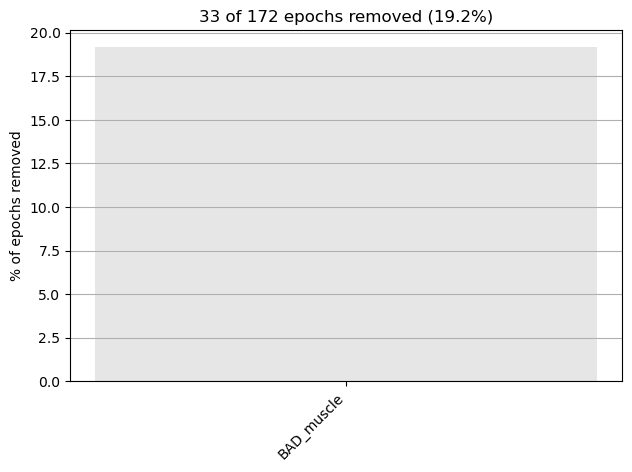

In [14]:
epochs.plot_drop_log();

A few percent of the trials were rejected due to MEG artifacts in the magnetometers.

Now we save the epoched data in an FIF-file. Note this file will include trials from the 2 subfiles.

In [17]:
epochs.save(deriv_file, overwrite=True)

## Plotting the trials
To show the trials for the left-condition for the MEG gradiometers write:

In [18]:
%matplotlib inline
epochs['cue_left'].plot(n_epochs=10,picks=['grad']);

Using qt as 2D backend.


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


The plot above shows 10 trials of type left; only gradiometers shown.

To show the trigger (stimulus channels) write:

In [19]:
%matplotlib inline
epochs['cue_left'].plot(n_epochs=1,picks=['stim']);

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


An example of the trigger channels for one trial.

Showing the trigger channels is often useful for verifying that correct trials have been selected. Note that STI001 to STI016 denote the individual trigger lines which are 'on' (1) or 'off' (0). The channel STI101 is a combination of the trigger lines ( STI101 = STI001 + 2 * STI002 + 4 * STI003 + 8 * STI004 + ...)

To show all the trials belonging to *left* for a representative gradiometer (MEG2343) use the plot_image function. In the following example we also lowpass filter the indvidual trials at 30 Hz and shorten them (crop) to a -100 to 400 ms interval:

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 20196 out of 20196 | elapsed:    7.1s finished


Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated


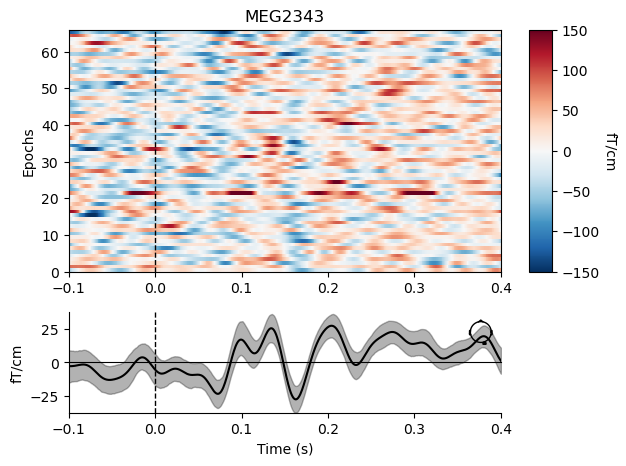

In [20]:
%matplotlib inline
epochs['cue_left'].filter(0.0,30).crop(-0.1,0.4).plot_image(picks=['MEG2343'],vmin=-150,vmax=150);

## Preregistration and publications

Publication, example:

"The data were segmented into intervals of 4.5 s, ranging from 2.5 s prior to stimulus onset and 2 s after. To ensure that no artefacts were missed, trials in which the gradiometers values exceeded 5000 fT/cm or magnetometers exceeded 5000 fT were rejected as well as trials previously annotated with muscle artefacts."
